### **1. the Big Picture**
**The main goal is to predict the median housing price in a California district based on various features (population, income, etc.).**

### **2. Frame the Problem**
##### **Housing Project Architecture**
| Property | Classification | Description |
| :--- | :---: | ---: |
| **Learning Type** | Supervised | The model is trained with labeled examples (median housing price). |
| **Task Type** | Regression | The goal is to predict a continuous numerical value. |
| **Feature Count** | Multiple Regression | The system uses multiple predictors (income, population, etc.). |
| **Output Count** | Univariate Regression | The system predicts only a single value per group of Blocks. |
| **Learning Mode** | Batch Learning | Data is static, fits in memory, and no continuous flow is required. |

### **3.Select a Performance Measure**

**1. Root Mean Square Error (RMSE)**
> RMSE is the preferred performance measure for regression tasks. It gives a higher weight to large errors (outliers), making it very sensitive to how well the model performs.
- Mathematical Formula:
    -  $$RMSE(\mathbf{X}, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} \left( h(\mathbf{x}^{(i)}) - y^{(i)} \right)^2}$$
        - $m$: The number of instances in the dataset.
        -  $\mathbf{x}^{(i)}$: A vector of all feature values for the $i^{th}$ instance.
        - $y^{(i)}$: The actual label (the desired output value).
        - $h$: The system's prediction function (also called a hypothesis).
        - $RMSE$: The cost function measured on the set of examples using your hypothesis $h$.
- When to use it:
    - When you want to penalize large errors more heavily.
    - When the errors are expected to follow a Gaussian (normal) distribution.

**2. Mean Absolute Error (MAE)**
> MAE (also called the Average Absolute Deviation) is used if there are many outlier districts in your dataset. It measures the average magnitude of the errors in a set of predictions, without considering their direction.
- Mathematical Formula:
> $$MAE(\mathbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(\mathbf{x}^{(i)}) - y^{(i)} \right|$$
- When to use it:
    - When your dataset has many outliers (e.g., a few districts with extreme, rare pricing).
    - When you want a linear representation of error (an error of $10 is twice as bad as $5).

## **Get The Data**

### **Downoald The Data**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_housing = pd.read_csv("../Datasets/housing.csv")

df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### **The Data Structure**

In [3]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df_housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
df_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


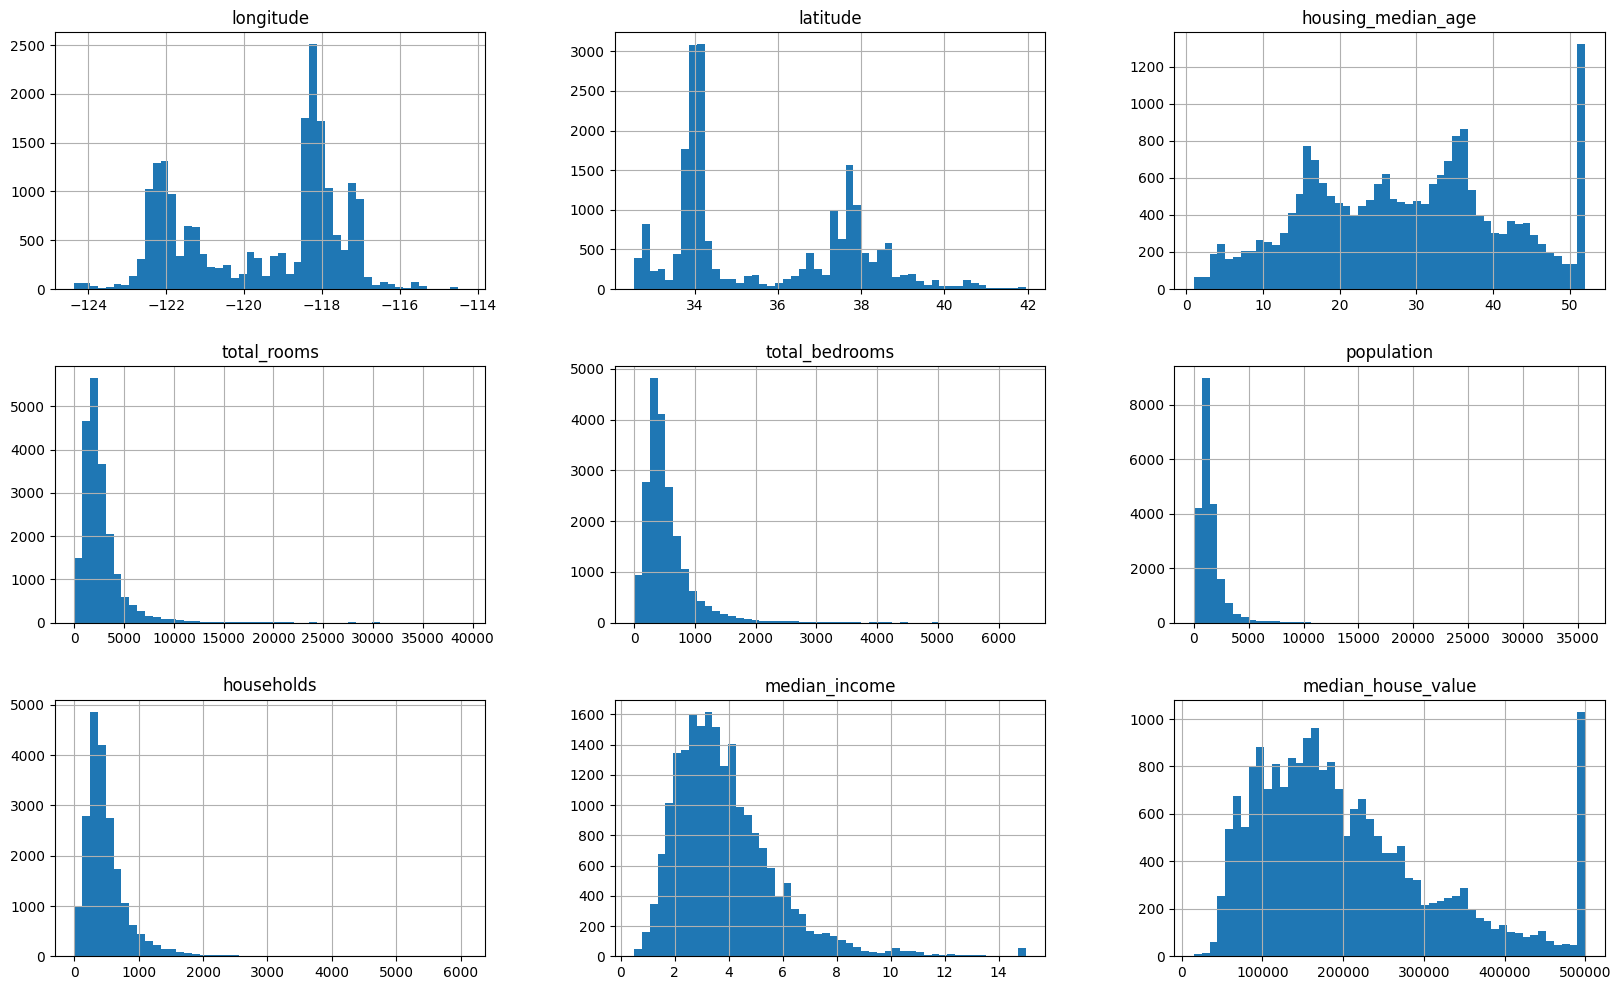

In [6]:
df_housing.hist(bins=50, figsize=(20, 12))

plt.show()

### **Create a Test Set**

In [7]:
def shuffle_and_split_data(df, test_ratio):
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[test_indices]

In [8]:
train_test, test_set = shuffle_and_split_data(df_housing, 0.2)

print(f"Train set size: {len(train_test)}")
print(f"Test set size: {len(test_set)}")

Train set size: 16512
Test set size: 4128


In [9]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

In [10]:
def split_data_with_id_hash(df, test_ratio, id_column):
    ids = df[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return df.loc[~in_test_set], df.loc[in_test_set]

In [11]:
df_housing_index = df_housing.reset_index()
train_test, test_set = split_data_with_id_hash(df_housing_index, 0.2, "index")

In [12]:
print(f"Train set size: {len(train_test)}")
print(f"Test set size: {len(test_set)}")

Train set size: 16512
Test set size: 4128


he main reason we use this specific hashing code instead of a simple "random" shuffle is consistency.

In a typical data science project, you will run your script dozens of times. If you use a standard random split, your "Training" and "Testing" sets will change every single time. This creates three major problems that hashing solves:

1. Preventing "Data Snooping"
If you run a random split over and over, your machine learning model will eventually "see" every single row of data during the training phase.
- **The Risk:** The model might memorize patterns from the test set.
- **The Result:** When you finally evaluate the model, it looks like it’s performing perfectly, but in reality, it just recognized data it already saw. This is called overfitting or data leakage.

2. Stability Across Updates
Imagine you have 1,000 rows of data today, and you collect 200 more tomorrow.
- **Random Split:** If you re-run a random split on 1,200 rows, the entire dataset gets shuffled. Rows that were in your "Test" set yesterday might move to the "Train" set today.
- **Hashing Split:** Because the hash of an ID (like an address or a serial number) never changes, all your original 1,000 rows will stay exactly where they were. The 200 new rows will simply be hashed and assigned to their respective sets without disturbing the old ones.

3. Reproducibility
If you are working on a team, you want your teammate to get the exact same training and test sets as you.
 - If you rely on a local "random seed," it might behave differently across different operating systems or Python versions.
 - Hashing is a mathematical certainty. The crc32 of the number 42 is the same on your computer, my computer, and a server in the cloud.

**Comparison: `np.random.seed()` vs. Hashing Split**

| Feature | `np.random.seed()` (Position-Based) | Hashing (Identity-Based) |
| :--- | :--- | :--- |
| **Primary Logic** | Shuffles data based on its **row position**. | Assigns data based on its **unique ID value**. |
| **Consistency** | Stable only if the dataset size stays the same. | Stable even if you add new data to the set. |
| **Adding New Rows** | **Fails:** Changes the split for old rows. | **Succeeds:** Old rows stay in the same set. |
| **Deleting Rows** | **Fails:** Shifts positions, causing data to swap sets. | **Succeeds:** Remaining IDs keep their assignment. |
| **Best Use Case** | Quick experiments on static/fixed datasets. | Production systems or datasets that grow over time. |
| **Complexity** | Very simple (one line of code). | Requires a hashing function and a unique ID. |

In [13]:
df_housing_id = df_housing.copy()
df_housing_id["id"] = df_housing["longitude"] * 1000 + df_housing["latitude"]

train_test, test_set = split_data_with_id_hash(df_housing_id, 0.2, "id")

print(f"Train set size: {len(train_test)}")
print(f"Test set size: {len(test_set)}")

Train set size: 16322
Test set size: 4318


**Comparison: Index-Based vs. Attribute-Based Hashing**

| Feature | Index Hashing (`reset_index`) | Attribute Hashing (Lat/Long) |
| :--- | :--- | :--- |
| **Identification** | Based on **Row Position**. | Based on **Physical Identity**. |
| **Adding New Data** | Stable **only** if appended at the end. | Stable regardless of where data is added. |
| **Deleting Rows** | **Fails:** Shifts indices, mixing sets. | **Succeeds:** Other rows remain unaffected. |
| **Sorting Data** | **Fails:** New positions change hashes. | **Succeeds:** Hash is tied to values, not order. |
| **Requirement** | No specific columns needed. | Requires columns that are unique & permanent. |
| **Reliability** | Low (fragile to data changes). | High (robust and production-ready). |

In [14]:
from sklearn.model_selection import train_test_split

train_test, test_set = train_test_split(df_housing, test_size=0.2, random_state=24)
print(f"Train set size: {len(train_test)}")
print(f"Test set size: {len(test_set)}")

Train set size: 16512
Test set size: 4128


**Stratified Sampling**
> In Machine Learning, Stratified Sampling is a technique used to ensure that your training and test sets are representative of the overall population.

> Instead of picking rows purely at random, you divide the data into homogeneous subgroups (called strata) and sample from each subgroup proportionally. This prevents "sampling bias," where a specific group might be accidentally over-represented or completely missing from your test set.

Why it matters in Machine Learning
- Most ML models assume that the data they are trained on is a "fair" slice of reality.
    - **The Problem:** If you are predicting house prices and $10\%$ of your data is "Luxury Mansions," a random split might accidentally put $0\%$ of those mansions in your test set.
Your model will never be evaluated on how it handles expensive homes.
    - **The Solution:** Stratified sampling guarantees that the $10\%$ luxury mansion ratio is maintained in both your training and test sets.
The Mathematical Rule

> The "Rule" of Stratified Sampling is to maintain the Probability Mass Function (PMF) of a specific categorical variable across your splits.

1. **The Proportion Formula**
For any given category (stratum) $h$, the number of samples $n_h$ we take from that group must follow the ratio of that group in the total population $N$:
- $$n_h = \left( \frac{N_h}{N} \right) \times n$$
    - $N_h$ = Number of elements in stratum $h$ in the full dataset.
    - $N$ = Total size of the full dataset.
    - $n$ = Desired size of your sample (e.g., your 20% test set).
    - $n_h$ = How many rows from stratum $h$ you must put in your sample.

2. **The Weight Constraint**
The sum of all samples from each stratum must equal your total target sample size:
- $$\sum_{h=1}^{L} n_h = n$$

**Comparison: Random vs. Stratified Sampling**

| Feature | Random Sampling | Stratified Sampling |
| :--- | :--- | :--- |
| **Goal** | General randomness. | Proportional representation. |
| **Key Advantage** | No prior knowledge of data needed. | Eliminates "sampling bias" for key features. |
| **Risk** | Small groups might be excluded by chance. | Requires you to pick the correct category (stratum). |
| **Data Size** | Works best on very large "Big Data". | Essential for small to medium datasets. |

In [15]:
df_housing["median_income_cat"] = pd.cut(df_housing["median_income"],
                                           bins=[0, 1.5, 3.0, 4.5, 6, np.inf], 
                                           labels=[1, 2, 3, 4, 5])

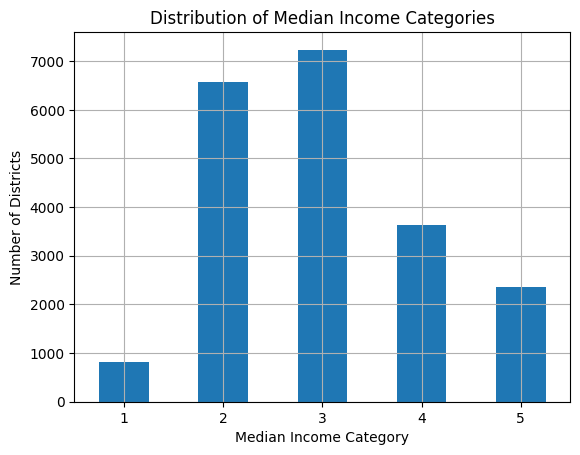

In [16]:
df_housing["median_income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Median Income Category")
plt.ylabel("Number of Districts")
plt.title("Distribution of Median Income Categories")

plt.show()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_split = []
for train_index, test_index in splitter.split(df_housing, df_housing["median_income_cat"]):
    strat_train_set_n = df_housing.iloc[train_index]
    strat_test_set_n = df_housing.iloc[test_index]
    strat_split.append([strat_train_set_n, strat_test_set_n])

In [18]:
strat_train_set, strat_test_set = strat_split[0]

In [19]:
print(f"Train set size: {len(strat_train_set)}")
print(f"Test set size: {len(strat_test_set)}")

Train set size: 16512
Test set size: 4128


In [20]:
# stratified single split 

strat_train_set, strat_test_set = train_test_split(df_housing,
                                                   test_size=0.2,
                                                   stratify=df_housing["median_income_cat"],
                                                   random_state=42)

In [21]:
strat_test_set["median_income_cat"].value_counts() / len(strat_test_set)

median_income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=42)

In [23]:
def get_proportion(df, column):
    return df[column].value_counts() /len(df)

In [24]:
compare_props = pd.DataFrame({
    "Overall": get_proportion(df_housing, "median_income_cat") * 100,
    "Stratified": get_proportion(strat_test_set, "median_income_cat") * 100,
    "Random": get_proportion(test_set, "median_income_cat") * 100,
}).sort_index()

compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100


compare_props

,Overall,Stratified,Random,Strat. %error,Rand. %error
median_income_cat,,,,,
1,3.982558,3.997093,4.239341,0.364964,6.447689
2,31.884690,31.879845,30.741279,-0.015195,-3.586081
3,35.058140,35.053295,34.520349,-0.013820,-1.533997
4,17.630814,17.635659,18.410853,0.027480,4.424292
5,11.443798,11.434109,12.088178,-0.084674,5.630821


**Proportional Analysis Table Breakdown**

| Column | Description |
| :--- | :--- |
| **Overall** | The true "Ground Truth" proportions of the dataset. |
| **Stratified** | Proportions in the test set using `StratifiedShuffleSplit`. |
| **Random** | Proportions in the test set using `train_test_split`. |
| **Rand. %error** | How much the random split deviated from reality (Lower is better). |
| **Strat. %error** | How much the stratified split deviated from reality (Should be near zero). |

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("median_income_cat", axis=1, inplace=True)

In [26]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


## **exploring the data**

In [27]:
df_housing_train_set = strat_train_set.copy()

In [28]:
df_housing_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


### **Visualizing Geographical Data**

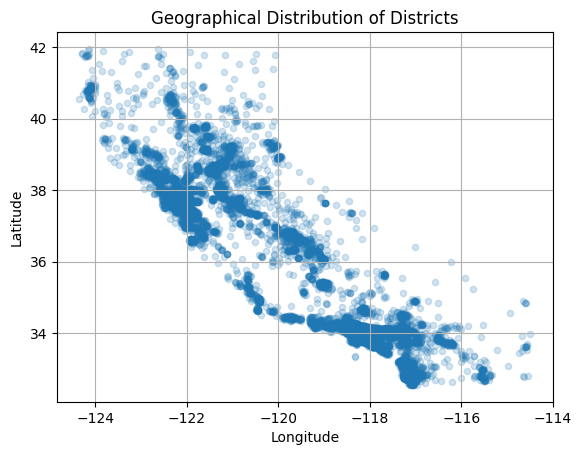

In [29]:
df_housing_train_set.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Districts")

plt.show()

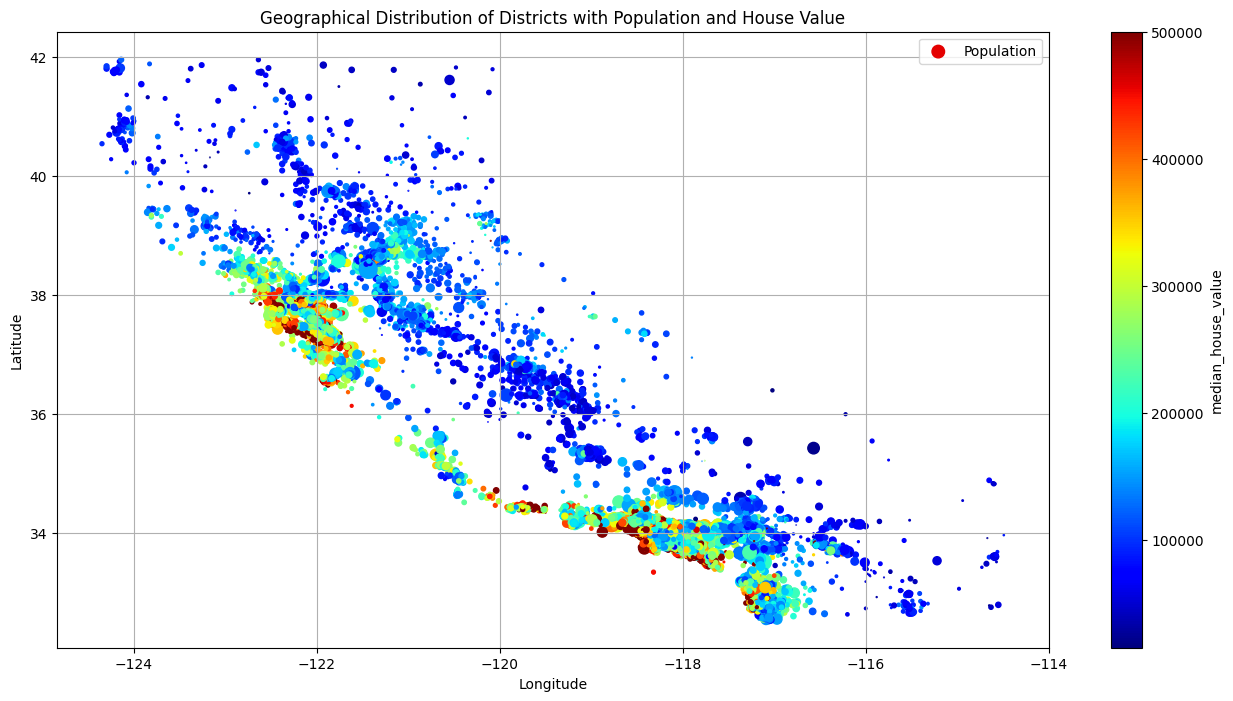

In [30]:
df_housing_train_set.plot(kind="scatter", 
                            x="longitude", 
                            y="latitude", 
                            grid=True, 
                            s=df_housing_train_set["population"] / 100, 
                            label="Population",
                            c="median_house_value",
                            cmap="jet",
                            colorbar=True, 
                            legend=True,
                            sharex=False,
                            figsize=(16,8))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Districts with Population and House Value")

plt.show()

### **Correlations**

>In the context of Machine Learning, Correlation is a statistical measure that expresses the extent to which two variables are linearly related. It tells us how much one variable changes when the other one does.

>If you are predicting house prices, you might find a high correlation between "Number of Rooms" and "Price." As one goes up, the other usually follows.

**The Mathematics: Pearson Correlation Coefficient**
>The most common way to measure correlation is the Pearson Correlation Coefficient, represented by the Greek letter $\rho$ (rho) for a population or $r$ for a sample.

The formula for $r$ is:
- $$r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$
**The "Rules" of the Result:**
- The value of $r$ always stays between $-1$ and $+1$:
    - $+1$ (Perfect Positive Correlation): As $X$ increases, $Y$ increases in a perfect straight line.
    - $0$ (No Linear Correlation): There is no visible linear relationship between the variables.
    - $-1$ (Perfect Negative Correlation): As $X$ increases, $Y$ decreases in a perfect straight line.

**Correlation in Machine Learning**

> Correlation is a fundamental tool during the Data Exploration (EDA) phase of an ML project. Here is how it relates to building models:

1. **Feature Selection**
- If a feature has a correlation near $0$ with your "Target" (the value you want to predict), it might not be very useful. Conversely, features with high absolute values (near $1$ or $-1$) are often your strongest predictors.
2. **Identifying Multicollinearity**
- In ML, we generally want features to be correlated with the target, but not with each other.
    - If two features (like "Square Feet" and "Number of Rooms") are $0.99$ correlated, they are providing redundant information.
    - This can confuse models like Linear Regression, making them unstable. This is called Multicollinearity.
3. **Detecting Non-Linearity**
- Pearson correlation only measures linear relationships. If your data forms a perfect U-shape (parabola), the correlation coefficient will be $0$.

>Important Rule: $r = 0$ does not mean there is no relationship; it just means there is no straight-line relationship.

In [31]:
corr_matrix = df_housing_train_set.corr(numeric_only=True)

corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [32]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

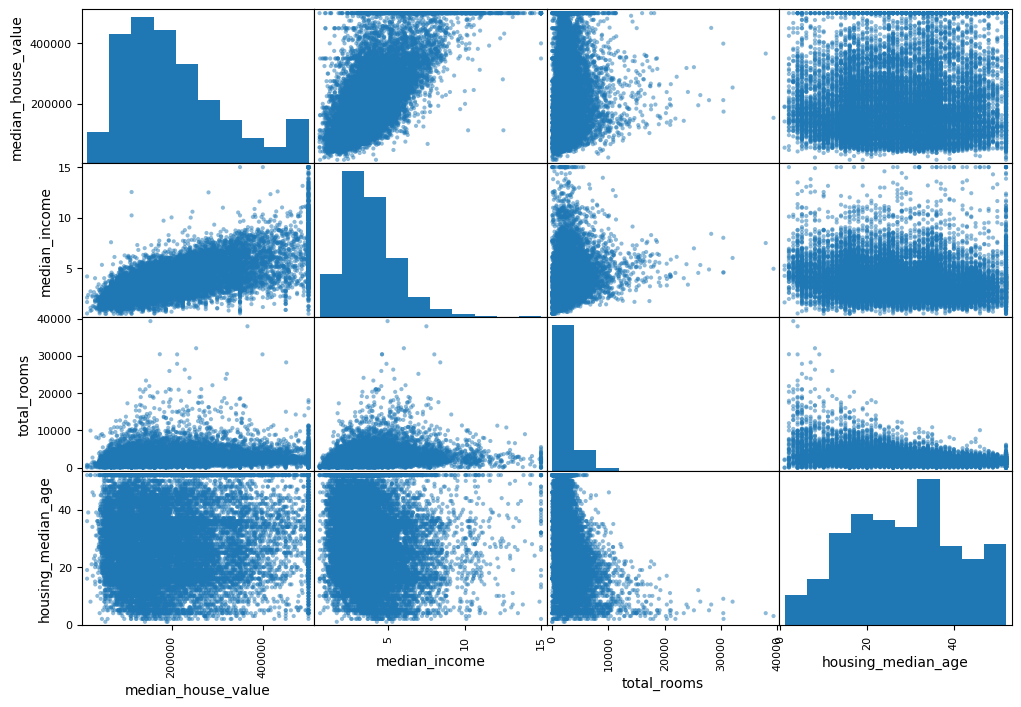

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df_housing_train_set[attributes], figsize=(12, 8))

plt.show()

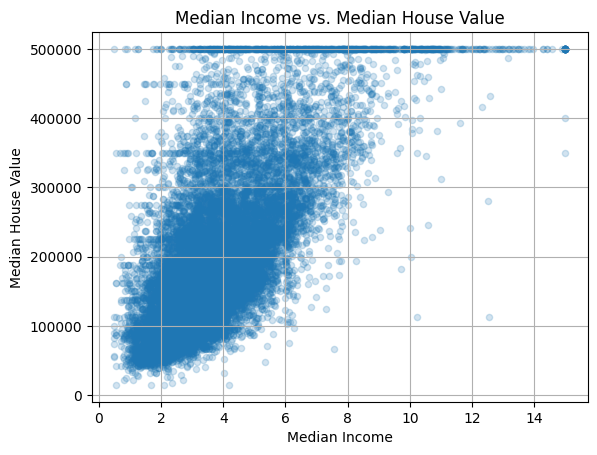

In [34]:
df_housing_train_set.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.2)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median Income vs. Median House Value")

plt.show()

### **Attribute Combinations**

In [35]:
df_housing_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [36]:
df_housing_train_set["rooms_per_house"] = df_housing_train_set["total_rooms"] / df_housing_train_set["households"]
df_housing_train_set["bedrooms_per_room"] = df_housing_train_set["total_bedrooms"] / df_housing_train_set["total_rooms"]
df_housing_train_set["people_per_house"] = df_housing_train_set["population"] / df_housing_train_set["households"]

In [37]:
df_housing_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_per_room,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [38]:
corr_matrix = df_housing_train_set.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_per_room    -0.256397
Name: median_house_value, dtype: float64

## **Preparation of the Data**

> automating data preparation through functions is far superior to manual cleaning.

- Here is a summary of the four key advantages:
    - **Reproducibility:** You can instantly apply the same cleaning process to new or updated datasets without starting from scratch.
    - **Reusability:** You create a personal library of tools that can be "plugged in" to future projects, saving time in the long run.
    - **Deployment Readiness:** These functions can be integrated into live systems, ensuring that raw incoming data is automatically formatted before it hits your model.
    - **Experimentation:** It allows you to quickly swap or combine different transformation techniques to find the one that yields the highest model accuracy.

In [39]:
df_housing_Features = strat_train_set.drop("median_house_value", axis=1) # drop method generate a copy of the data frame without affecting the original data frame
df_housing_target = strat_train_set["median_house_value"].copy()

In [40]:
df_housing_Features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


In [41]:
df_housing_target

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

### **Cleaning the data**

**imputation**

> in data science, imputation is the process of replacing missing data with substituted values. Since most machine learning algorithms cannot handle "NaN" (Not a Number) or null values, imputation is a critical step in the data preparation pipeline.

> Think of it as "filling in the blanks" using logic rather than just deleting the rows with missing information.

1. **Why Impute instead of Delete?**

When you encounter missing values (like a missing entry for households), you have two choices:
- **Deletion:** Remove the row or column. This is risky because you might lose 20-30% of your data, leading to selection bias.
- **Imputation:** Keep the data points and estimate the missing value. This preserves the sample size and often leads to a more robust model.

2. **Common Imputation Techniques**

**A. Statistical Measures (Univariate)**

This involves looking at one column and calculating a replacement value based on its own distribution.
- **Mean Imputation:** Replace missing values with the average. Best for normally distributed data without outliers.
- **Median Imputation:** Replace with the middle value. This is much better for skewed data (like income or households) because it isn't "pulled" by extreme outliers.
- **Mode Imputation:** Replace with the most frequent value. Usually used for categorical data (e.g., "City" or "Color").

**B. Constant Value**

Replacing missing values with a specific flag like 0, "Unknown", or -999. This tells the model that the data was missing for a reason.

**C. Predictive Imputation (Multivariate)**

Instead of just looking at one column, you use the other features to predict the missing value.
- **K-Nearest Neighbors (KNN):** Find the 5 most similar rows to the one with the missing value and average their values.
- **Iterative Imputation (MICE):** A sophisticated method where the model treats the feature with missing values as a "target" and uses all other features as predictors in a loop.

3. **The "Households" Example**

If you have a missing value in the households column for a specific district:
- **Mean/Median:** You take the average number of households across the entire state and plug it in.
- **Predictive:** You look at the population and total_rooms for that district. If the population is high, the model will intelligently guess a higher number for households.

4. **Critical Warning: Data Leakage**

One of the biggest mistakes in imputation is calculating the mean/median using the entire dataset before splitting it into "Training" and "Testing" sets.
- **The Rule:** You must calculate the imputation value (e.g., the median) on your training set only, and then apply that same value to your test set. If you use the test set's data to calculate the mean, you have "leaked" future information into your model.

In [42]:
# Mehods of Imputation

#df_housing_Features.dropna(subset=["total_bedrooms"], inplace=True) - option 1: get rid of the corresponding districts
#df_housing_Features.drop("total_bedrooms", axis=1, inplace=True) - option 2: get rid of the whole attribute

# median = df_housing_Features["total_bedrooms"].median() - option 3: Set the missing values to some value (imputation) 
# df_housing_Features["total_bedrooms"].fillna(median, inplace=True)

In [43]:
from sklearn.impute import SimpleImputer

# The main benefit of using Scikit-learn's imputation classes is that it can be easily integrated into a pipeline and it can be applied to both the training set 
# validation set and the test set without data leakage.
impute = SimpleImputer(strategy="median")

In [44]:
df_housing_Features_numerical = df_housing_Features.select_dtypes(include=[np.number])

df_housing_Features_numerical.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [45]:
# fit method computes the median of each attribute and stores the result in the imputer object
impute.fit(df_housing_Features_numerical)

impute.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [46]:
X = impute.transform(df_housing_Features_numerical)

X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]], shape=(16512, 8))

**Scikit-Learn** is the industry standard: its API is built on a logical, "Lego-like" structure where every piece fits together predictably.

1. The "Big Three" Object Types

Scikit-Learn categorizes every tool into one of three buckets based on what it does to the data.
| Type | Key Method | Description |
| :--- | :--- | :--- |
| **Estimators** | `fit()` | Calculates parameters based on a dataset (e.g., finding the median). |
| **Transformers** | `transform()` | Applies learned parameters to modify the data (e.g., filling missing values). |
| **Predictors** | `predict()` | Makes guesses on new data and evaluates quality via `score()`. |

> **Pro Tip:** Many objects are both Estimators and Transformers. They offer a fit_transform() method which is faster and more efficient than calling them separately.

2. Inspection: "The Underscore Rule"

Scikit-Learn makes it very easy to see what is happening "under the hood."
- **Before fitting:** You set hyperparameters (like strategy="median"). You can access these anytime: imputer.strategy.
- **After fitting:** Any value the model learned from your data is stored in a variable ending with an underscore.
    - **Example:** imputer.statistics_ shows the actual median values calculated for each column.

3. Practical Design Philosophy

The API follows three "common sense" rules to keep things simple:
- **Nonproliferation of classes:** It doesn't invent weird new data formats. It uses standard NumPy arrays and Pandas DataFrames. This makes it compatible with almost every other Python library.
- **Composition:** You can stack these blocks together. You can take a SimpleImputer, a StandardScaler, and a LinearRegression model and wrap them into a single Pipeline object that acts as one unit.
- **Sensible Defaults:** You don't need to be a math genius to start. Scikit-Learn provides "best guess" settings for most parameters so you can get a working model immediately.

**Summary Table: API at a Glance**
| Action | Method | Object Role |
| :--- | :--- | :--- |
| **Learn** from data | `fit(X_train)` | Estimator |
| **Change** data | `transform(X_new)` | Transformer |
| **Estimate & Change** | `fit_transform(X_train)` | Transformer |
| **Guess** a value | `predict(X_test)` | Predictor |
| **Evaluate** quality | `score(X_test, y_test)` | Predictor |

In [47]:
df_housing_Features_numerical = pd.DataFrame(X, columns=df_housing_Features_numerical.columns, index=df_housing_Features_numerical.index)

df_housing_Features_numerical.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [48]:
# tcheck if the imputation worked for total_bedrooms
df_housing_Features_numerical.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### **Handling Text and Categorical Attributes**

1. **Ordinal Encoding**

> **When to use it:** When the categories have a natural rank or scale. The order matters.
- Examples:
    - **Ratings:** ["Poor", "Average", "Good", "Excellent"]
    - **Education:** ["High School", "Bachelors", "Masters", "PhD"]
    - **Size:** ["Small", "Medium", "Large"]

> **How it works:** It assigns a unique integer to each category based on order (0, 1, 2, 3...).

> **the Risk:** If you use this on data without order (like colors), the Machine Learning model will mistakenly think that "Red" (2) is mathematically "greater" than "Blue" (1), which can confuse the algorithm.

2. One-Hot Encoding

> **When to use it:** When the categories are Nominal (no inherent order). They are just names.
- Examples:
    - **Ocean Proximity:** ["Inland", "Near Ocean", "Near Bay"] (from your housing dataset)
    - **Colors:** ["Red", "Yellow", "Green"]
    - **Cities:** ["Paris", "Agadir", "New York"]

> **How it works:** it creates a new binary column (0 or 1) for every single category.

> **The Risk:** "The Curse of Dimensionality." If you have a column with 1,000 unique cities, One-Hot Encoding will add 1,000 new columns to your data, making it huge and slow to process.

**Encoding Comparison (Ordinal vs. One-Hot)**
| Feature | Ordinal Encoding | One-Hot Encoding |
| :--- | :--- | :--- |
| **Relationship** | Ordered / Ranked (e.g., Small, Medium, Large) | Unordered / Equal (e.g., Red, Blue, Green) |
| **Output** | One single column of integers (0, 1, 2...) | Multiple binary columns (0 or 1) |
| **Data Nature** | Categorical Ordinal | Categorical Nominal |
| **Risk** | Can imply a math order where none exists | Creates "Sparse" data (too many columns) |
| **Best For** | Tree-based models (Random Forest, XGBoost) | Linear models, Neural Networks |

In [49]:
df_housing_Features_cat =  df_housing_Features[["ocean_proximity"]]

df_housing_Features_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [50]:
df_housing_Features_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

In [51]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_housing_Features_cat_encoded = ordinal_encoder.fit_transform(df_housing_Features_cat)

df_housing_Features_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [52]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [53]:
from sklearn.preprocessing import OneHotEncoder

# sparse=False : return a regular (dense) NumPy array instead of a sparse matrix. This can be useful when the number of categories is small and the resulting array is not too large.
hot_encoded = OneHotEncoder()
df_housing_Features_cat_hot_encoded = hot_encoded.fit_transform(df_housing_Features_cat)

# Outpupt SciPy sparse matrix
df_housing_Features_cat_hot_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

**Note:** A sparse matrix is a very efficient representation for matrices that contain mostly zeros, it only stores the nonzero values.

In [54]:
df_housing_Features_cat_hot_encoded.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [55]:
hot_encoded.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "<1H OCEAN"]})

pd.get_dummies(df_test, dtype=np.int8)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND
0,0,1
1,1,0


In [57]:
hot_encoded.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

This is a classic question. While both **pd.get_dummies()** and Scikit-Learn's **OneHotEncoder** do the same mathematical operation (turning categories into 0s and 1s), they are used for very different purposes in a Machine Learning workflow.

> The main difference is that OneHotEncoder is designed for production pipelines, while get_dummies is designed for quick data exploration.

| Feature | pd.get_dummies | sklearn OneHotEncoder |
| :--- | :--- | :--- |
| **Goal** | Quick visualization/EDA | Building ML Pipelines |
| **Memory** | Forgetful (re-calculates every time) | Remembers (stores categories in `.categories_`) |
| **Missing Values** | Harder to handle | Integrated with `handle_unknown='ignore'` |
| **Data Format** | Returns a clean DataFrame | Returns a Matrix (requires conversion for view) |

**Why OneHotEncoder is better for ML**

Imagine you train your model on a dataset that has City: ["Paris", "Agadir"].
- get_dummies will create two columns: City_Paris and City_Agadir.
- If your test set only contains "Agadir", get_dummies will only create one column. Your model will then crash because it expects two inputs.

> **OneHotEncoder** solves this by "remembering" the structure from the fit() step and applying it exactly the same way to the transform() step, even if some categories are missing in the new data

In [58]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["INLAND", "UNKNOWN"]})
pd.get_dummies(df_test_unknown, dtype=np.int8)

,ocean_proximity_INLAND,ocean_proximity_UNKNOWN
0,1,0
1,0,1


In [59]:
hot_encoded.handle_unknown = "ignore"
hot_encoded.transform(df_test_unknown).toarray()


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

**"High Cardinality" problem**: when a category has too many unique values (like 200 countries), One-Hot Encoding creates too many columns, which hurts model performance.

Here are the three professional strategies to handle this:

1. **Feature Engineering (Domain Knowledge)**
> Instead of using the category name, replace it with a meaningful number that describes it.
- **Example:** Instead of Country_Name, use Country_GDP or Population.
- **Example:** Instead of Ocean_Proximity, use Distance_to_Coast_KM.
- **Benefit:** You reduce 200 columns down to 1 or 2 high-value numerical columns.

2. **Specialized Encoders**
>Use the category_encoders library for more sophisticated mathematical mappings.
- **Target Encoding:** Replaces a category with the average value of the "target" (e.g., replace "Agadir" with the average house price in Agadir).
- **Hash Encoding:** Uses a hashing function to map many categories into a fixed, smaller number of columns.

3. **Embeddings (Deep Learning)**
> When using Neural Networks, you use Representation Learning.
- The model assigns each category a low-dimensional vector (e.g., 5 numbers instead of 200).
- During training, the model "learns" to put similar categories closer together in this vector space.

| Strategy | Action | Best Used When... |
| :--- | :--- | :--- |
| **Numerical Proxy** | Replace category with a related stat (GDP, Distance). | You have good domain knowledge. |
| **Target Encoding** | Replace category with the mean of the target variable. | You have many categories but limited columns. |
| **Embeddings** | Use "Representation Learning" (dense vectors). | You are using Neural Networks / Deep Learning. |
| **Hashing** | Use a hash function to limit the number of columns. | Memory is very limited and categories are huge. |

In [60]:
# When you fit estimators in scikit-learn the estimators store the information they have learned during the fit in their attributes features_name_in_ and for transformers 
# provide a get_feature_names_out() method that returns the names of the features after transformation. 
# This information is used when you call the transform method to ensure that the same encoding is applied to new data, even if it contains categories that were not seen during the fit.

hot_encoded.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [61]:
hot_encoded.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [62]:
df_output = pd.DataFrame(hot_encoded.transform(df_test_unknown).toarray(), 
                            columns=hot_encoded.get_feature_names_out(), 
                            index=df_test_unknown.index,
                            dtype=np.int8)

df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0,1,0,0,0
1,0,0,0,0,0


### **Feature Scaling and Transformation**

**Feature scaling**
> is one of the most important data preprocessing steps in Machine Learning. It is the process of normalizing the range of independent variables (features) of data.
- In many datasets, features have different scales. For example, in your housing data:
    - **Rooms:** ranges from 1 to 50.
    - **Income:** ranges from 10,000 to 500,000.
If you don't scale them, most ML algorithms will think the Income is "more important" than the number of rooms simply because the numbers are bigger.

1. **Why do we need it?**
 - **Gradient Descent Convergence:** Algorithms like Linear Regression or Neural Networks find the "solution" faster if the data is on a similar scale. If not, the "path" to the solution becomes zig-zagged and slow.
 - **Distance-based Algorithms:** Models like KNN or SVM calculate the distance between points. If one feature has a massive range, it will dominate the distance calculation, making the other features invisible.
 - **Regularization:** If you use Lasso or Ridge regression, the penalty is applied to the coefficients. Unscaled data leads to unfair penalties.
2. The Two Main Methods

**A. Min-Max Scaling (Normalization)**
> This squashes all values into a specific range, usually 0 to 1.
 - **Formula:** $$x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}$$
 - **Best for:** Algorithms that don't assume a specific distribution (like Neural Networks).
 - **Cons:** It is very sensitive to outliers. If you have one house that costs $100M, it will crush all other houses down to 0.0001.

**B. Standardization (Z-score Scaling)**
> This centers the data around a mean of 0 with a standard deviation of 1.
 - **Formula:** $$x_{new} = \frac{x - \mu}{\sigma}$$
 - **Best for:** Algorithms that assume the data follows a Gaussian (normal) distribution (like Logistic Regression, SVM, or Linear Regression).
 - **Pros:** Much less affected by outliers.

![Image comparing normalization and standardization distributions](../Images/normalization_vs_standardization.png)

| Method | Scikit-Learn Class | Range | Sensitivity to Outliers |
| :--- | :--- | :--- | :--- |
| **Normalization** | `MinMaxScaler` | 0 to 1 | High (Outliers distort everything) |
| **Standardization** | `StandardScaler` | ~ -3 to 3 | Low (Handles outliers better) |
| **Robust Scaling** | `RobustScaler` | Varies | Very Low (Uses medians/quartiles) |

In [63]:
# fit the estimator MinMaxScaler to the training only data and then use the fitted estimator to transform the training set, validation set and test set. This way you avoid data leakage 
# and ensure that the same scaling is applied to all sets.

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
df_housing_Features_numerical_min_max_scaled = min_max_scaler.fit_transform(df_housing_Features_numerical)

In [64]:
df_housing_Features_numerical_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]], shape=(16512, 8))

In [65]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
df_housing_Features_numerical_std_scaled = std_scaler.fit_transform(df_housing_Features_numerical)

In [66]:
df_housing_Features_numerical_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

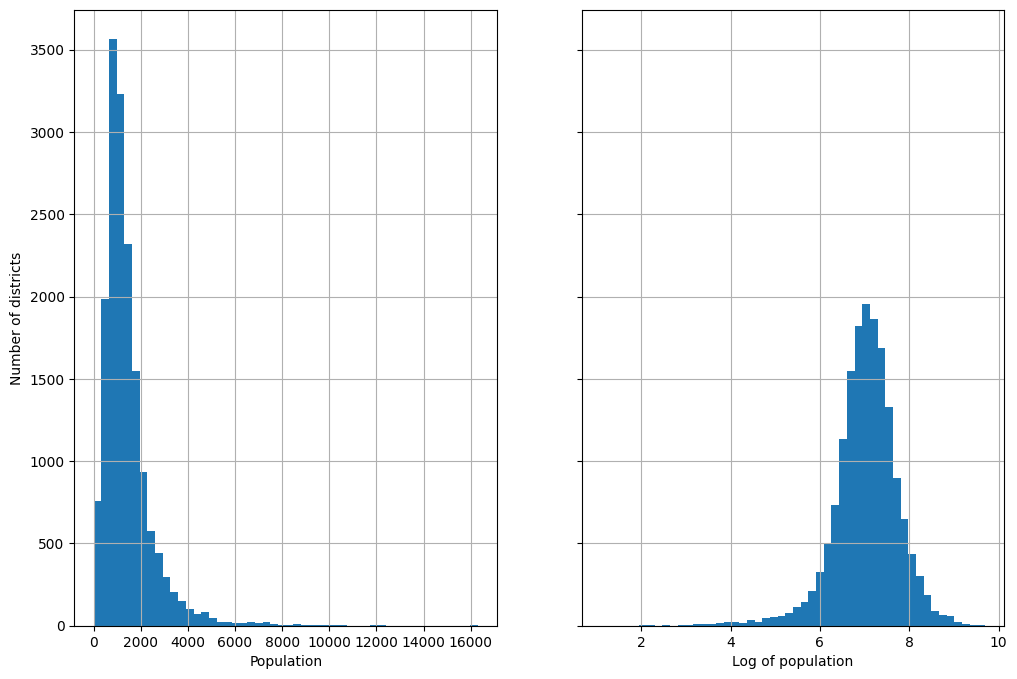

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
df_housing_Features["population"].hist(ax=axs[0], bins=50)
df_housing_Features["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")


plt.show()

The Problem: The **"Squash" Effect**

- In a heavy-tailed feature (like population or income):
    - Min-Max Scaling: One massive city pushes every other city's value to 0.00001.
    - Standardization: The mean is pulled so far by outliers that the standard deviation doesn't accurately represent the "normal" data.

**The Solution: Power Transformations**
> Before scaling, you must "shrink" the tail to make the data more symmetrical (bell-shaped). This makes it easier for the model to "see" the patterns.

| Transformation | When to use it? | Effect on Data |
| :--- | :--- | :--- |
| **Square Root** | Moderate heavy tail | Pulls high values in slightly to reduce skew. |
| **Power (0 to 1)** | Customizable tail | Shrinks the range of large numbers based on the exponent. |
| **Logarithm (Log)** | Very long "Power Law" tails | Converts exponential growth into linear steps; creates a Bell Curve. |
| **Goal** | Symmetrical Data | Makes the distribution Gaussian so Scalers work effectively. |

**The "Log" Example**
- In a Power Law distribution (like population):
    - A city of 1,000 is common.
    - A city of 10,000 is only 10 times less frequent.
    - By taking the Log, you transform this exponential scale into a linear one, making the distribution look like a Gaussian (Bell Curve).

| Concept | Description |
| :--- | :--- |
| **Heavy Tail** | Data where extreme values are common, not rare. |
| **The Danger** | Standard scaling "squashes" 90% of data into a tiny range. |
| **The Fix** | Pre-process with Log or Square Root transformations. |
| **Goal** | Make the distribution roughly symmetrical (Gaussian). |

> A **Gaussian distribution** (also known as a Normal distribution or Bell Curve) is the most important probability distribution in statistics and Machine Learning.
> It describes data that clusters around a central mean, where extreme values become increasingly rare as you move away from the center.
1. **Key Characteristics**
- A Gaussian distribution is defined by two parameters:
    - **Mean ($\mu$):** The center of the "bell." This is where the peak of the curve is located.
    - **Standard Deviation ($\sigma$):** The width of the bell. It measures how spread out the data is.
    - **Symmetry:** The left side is a mirror image of the right side.
    - **Central Tendency:** The Mean, Median, and Mode are all at the exact same point (the center).
    - **Asymptotic:** The "tails" of the curve get closer and closer to zero but never actually touch the horizontal axis.
2. The 68-95-99.7 Rule (Empirical Rule)
- In a perfect Gaussian distribution, the data follows a very strict mathematical breakdown:
    - **68%** of the data falls within 1 standard deviation ($\pm 1\sigma$) of the mean.
    - **95%** of the data falls within 2 standard deviations ($\pm 2\sigma$) of the mean.
    - **99.7%** of the data falls within 3 standard deviations ($\pm 3\sigma$) of the mean

![Gaussian distribution](../Images/Gaussian-distribution.jpeg)

3. Why is it so important in Machine Learning?
- **The Central Limit Theorem:** This states that if you take enough random samples from any distribution, the mean of those samples will eventually form a Gaussian distribution. It’s the "natural state" of many things in the world (heights, IQ scores, errors in measurement).
- **Model Assumptions:** Many algorithms (like Linear Regression, Logistic Regression, and LDA) are mathematically designed with the assumption that your input features follow a Gaussian distribution.
- **Algorithm Performance:** As you read in your text, models "don't like" heavy tails. If you transform your data (using Log or Square Root) to look Gaussian, your model can distinguish the patterns much more effectively.

| Property | Description |
| :--- | :--- |
| **Shape** | Symmetrical Bell Curve |
| **Center** | Mean = Median = Mode |
| **Parameters** | Mean ($\mu$) and Standard Deviation ($\sigma$) |
| **68% Range** | $\pm 1$ Standard Deviation |
| **95% Range** | $\pm 2$ Standard Deviations |
| **Ideal For** | Linear Regression, Logistic Regression, Gaussian Naive Bayes |

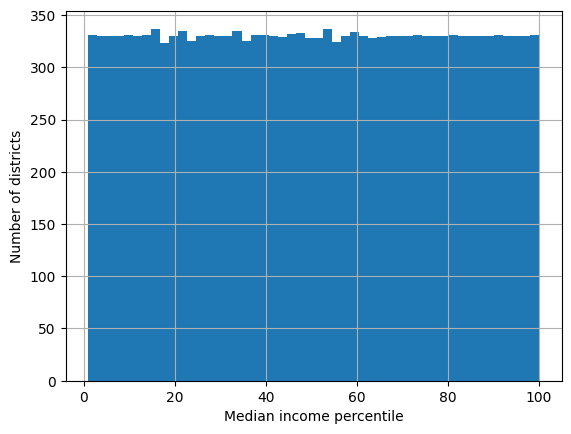

In [68]:
percentiles = [np.percentile(df_housing_Features_numerical["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(df_housing_Features_numerical["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

**Bucketizing (also known as Binning)** is the process of turning a continuous numerical feature (like age, income, or house prices) into a discrete categorical feature by grouping values into "buckets" or "bins."

> It essentially simplifies the data by saying: "I don't care exactly how many dollars you make; I only care if you are in the Low, Medium, or High income bracket."

1. **Why use Bucketizing?**
- **Handling Non-linear Relationships:** Sometimes, the relationship between a feature and the target isn't a straight line. For example, people aged 0–10 and 70–80 might have similar healthcare costs, while people aged 30–40 are different. Bucketizing allows the model to treat these groups uniquely.
- **Reducing Noise:** Small fluctuations in data (e.g., the difference between a house built in 1954 vs 1955) might just be noise. Grouping them into "1950s" removes that jitter.
- **Fixing Heavy Tails:** As you read earlier, heavy tails can "squash" data. Bucketizing groups the rare, high-value outliers into a single "Maximum" bucket, neutralizing their negative effect on the scale.

2. **Common Bucketizing Strategies**

| Strategy | How it works | Best used when... |
| :--- | :--- | :--- |
| **Uniform (Equal Width)** | Every bucket covers the same numerical range (e.g., 0-10, 10-20). | Data is evenly distributed and you want to keep the scale consistent. |
| **Quantile (Equal Frequency)** | Each bucket contains the same number of data points. | You have skewed data or heavy tails (prevents "empty" buckets). |
| **Custom / Manual** | You define boundaries based on logic (e.g., Age 0-18 = "Minor"). | You have specific domain knowledge or business categories. |

3. **Summary**

| Concept | Definition |
| :--- | :--- |
| **Bucketizing** | Converting continuous numbers into discrete intervals. |
| **Binning** | Another name for bucketizing. |
| **Quantile Binning** | Dividing data so each bin has roughly the same amount of samples. |
| **Main Benefit** | Simplifies complex relationships and handles outliers. |
| **Main Risk** | You lose the "precision" of the exact numerical value. |

A **Multimodal distribution** is a probability distribution that has two or more peaks (modes).

While a Gaussian distribution is "unimodal" (one peak), a multimodal distribution suggests that your data actually contains multiple distinct groups hidden inside a single feature.

1. **Visualizing the Peaks**
- **Unimodal:** One clear peak (like a bell curve).
- **Bimodal:** Two peaks. This often happens if you mix two different populations (e.g., the heights of men and women combined into one chart).
- **Multimodal:** Three or more peaks. This looks like a "mountain range."

2. **Why does this happen in Data Science?**
> If you see multiple peaks in a feature like house_prices or median_income, it is a signal that your data is not "one thing." It usually indicates:
- **Hidden Categories:** For example, house prices might have one peak for "suburban homes" and another peak for "luxury downtown penthouses."
- **Seasonality:** Sales data might have peaks in "Summer" and "Winter," but look messy when viewed as a whole year.
- **Geographic Splits:** In your housing data, a multimodal distribution in latitude represents the different major clusters of cities (e.g., one peak for Los Angeles and one for San Francisco).

3. **How to handle it?**
- Machine learning models often struggle with multimodal data because they try to find a single "average" center that doesn't actually exist. You can fix this by:
    - **Radial Basis Function (RBF) Kernels:** Creating a new feature that measures the distance to each peak (e.g., "Distance to Peak A" and "Distance to Peak B").
    - **Bucketizing:** Breaking the peaks into separate categories (as we discussed with binning).
    - **Clustering:** Using an algorithm like K-Means to identify the groups and adding the "Cluster ID" as a new feature.

4. Summary

| Distribution Type | Number of Peaks | What it implies... |
| :--- | :--- | :--- |
| **Unimodal** | 1 | The data comes from a single, consistent population. |
| **Bimodal** | 2 | There are likely two distinct groups mixed together. |
| **Multimodal** | 3+ | The data contains multiple clusters or sub-populations. |
| **Best Fix** | RBF / Clustering | Give the model a way to "see" each peak separately. |

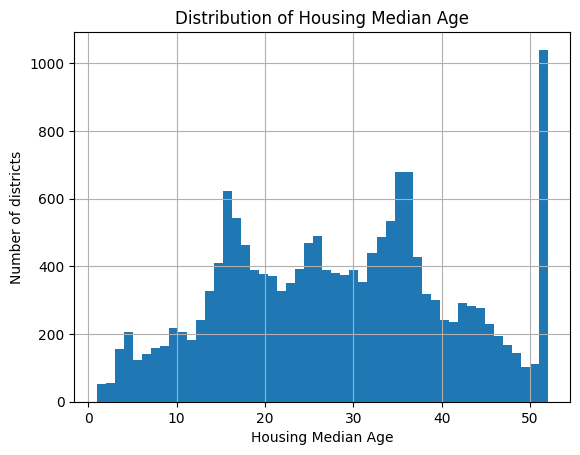

In [69]:
df_housing_Features["housing_median_age"].plot.hist(bins=50, grid=True)
plt.xlabel("Housing Median Age")
plt.ylabel("Number of districts")
plt.title("Distribution of Housing Median Age")

plt.show()

> In Machine Learning, a **Gaussian Radial Basis Function (RBF)** is a mathematical trick used to create features that measure similarity to a specific point (usually a peak or a landmark in your data).
> It is especially powerful for transforming multimodal distributions (those with multiple peaks) into something a model can easily understand.

1. **How it Works**
> Think of a Gaussian RBF as a "proximity sensor.
- "You pick a landmark (a point in your data, like the center of a city).
- The RBF outputs a value between 0 and 1.
- If a data point is exactly at the landmark, the output is 1.
- As the point moves away from the landmark, the output drops toward 0 in a bell-shaped curve.

2. **The Formula**
- The most common RBF is the Gaussian RBF:
    - $$\phi(x, \ell) = \exp(-\gamma \|x - \ell\|^2)$$
    - **$x$:** Your input data point.
    - **$\ell$:** The Landmark (the center of the peak).
    - **$\gamma$ (Gamma):** This controls how "wide" the bell is.
        - A **small $\gamma$** creates a wide, gentle slope (faraway points still feel "similar").
        - A **large $\gamma$** creates a very thin, sharp spike (only points very close to the landmark get a high score).

3. **Why use it for Multimodal Data?**
> If your latitude has two peaks (one for LA and one for San Francisco), a linear model doesn't know what to do. By adding two RBF features:
- **Feature A:** "Similarity to LA
- **"Feature B:** "Similarity to San Francisco"
> **You have effectively told the model:** "Tell me how close this house is to these two specific expensive hubs." The model can now assign different weights to each peak.

4. Summary

| Component | Name | Role |
| :--- | :--- | :--- |
| **$x$** | Input | The data point you are currently looking at. |
| **$\ell$** | Landmark | The "center" or peak you want to measure distance from. |
| **$\gamma$** | Gamma | Controls the influence; defines how quickly the similarity drops. |
| **Output** | Similarity Score | A value from 0 to 1 (1 = Identical, 0 = Very Different). |
| **Use Case** | Multimodal Data | Turning distance from a "peak" into a useful feature. |

In [70]:
from sklearn.metrics.pairwise import rbf_kernel

age_similarity_35 = rbf_kernel(df_housing_Features[["housing_median_age"]], [[35]], gamma=0.1)

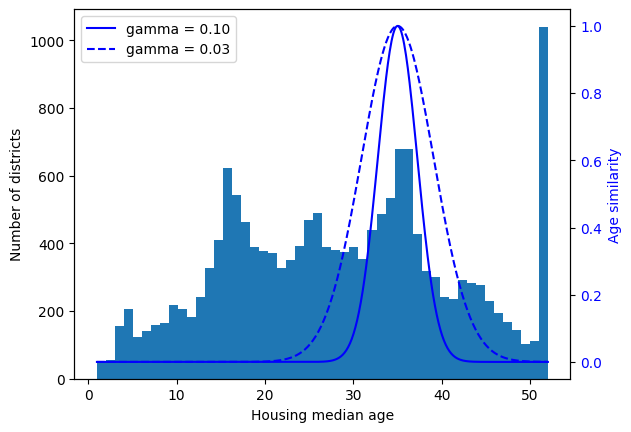

In [71]:
ages = np.linspace(df_housing_Features_numerical["housing_median_age"].min(),
                   df_housing_Features_numerical["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(df_housing_Features_numerical["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")


plt.show()

> In statistics, a **Heavy Tail** describes a distribution where extreme values (outliers) occur much more frequently than you would expect in a normal "bell curve."

> In a normal distribution, values far from the mean are "exponentially rare." In a heavy-tailed distribution, those values are just "moderately rare," creating a long, thick tail on the graph.

1. **Visualizing the Tail**
- **The "Head":** The main part of the distribution where most data points sit.
- **The "Tail":** The part of the graph that stretches out to the right (positive skew) or left (negative skew).
- **"Heavy" vs. "Thin":** A thin tail (like heights of people) drops to zero quickly. A heavy tail (like wealth or city populations) stays above zero for a very long time.

2. **Why Heavy Tails "Break" Machine Learning**
- Most ML models rely on Feature Scaling (like Standardization or Min-Max Scaling). Heavy tails cause two major issues:
    - **The Outlier Dominance:** In Min-Max scaling, a single extreme value (a "Black Swan") will push every other data point to nearly zero.
    - **Mean/Variance Instability:** The average (mean) gets pulled so far by the tail that it no longer represents the "typical" data point.

3. **The Solution: Transforming the Tail**
> To make a model perform better, you need to "shrink" the heavy tail before feeding it into the algorithm.

| Technique | How it works | When to use it |
| :--- | :--- | :--- |
| **Log Transformation** | Takes the $log(x)$ of the feature. | For "Power Law" distributions (extremely long tails, like population). |
| **Square Root** | Takes the $\sqrt{x}$ of the feature. | For moderate tails where the skew is present but not extreme. |
| **Power (0 to 1)** | Raises feature to a power (e.g., $x^{0.25}$). | When you need to fine-tune exactly how much to shrink the tail. |
| **Box-Cox / Yeo-Johnson** | Statistically finds the optimal power. | When you want the computer to automatically decide the best math. |

4. Summary

| Concept | Key Characteristic | Example in Real World |
| :--- | :--- | :--- |
| **Heavy Tail** | High probability of extreme outliers. | Wealth, Populations, Social Media followers. |
| **The "Squash"** | Scaling makes 99% of data look identical. | Comparing a village of 100 people to Tokyo. |
| **The Log Fix** | Compresses the tail, making it look Gaussian. | $log(1,000,000)$ is only twice $log(1,000)$. |
| **The Goal** | Symmetrical distribution. | Helping models "see" differences in the majority of data. |

![Cauchy distribution heavy tail](../Images/Cauchy_distribution_heavy_tail.png)

In [72]:
from sklearn.linear_model import LinearRegression

# The target variable (median_house_value) is scaled using StandardScaler to ensure that it has a mean of 0 and a standard deviation of 1. This is important for linear regression 
# models, as it can help improve the convergence of the optimization algorithm and prevent issues related to different scales of features.
target_scaler = StandardScaler()
scaled_label = target_scaler.fit_transform(df_housing_target.to_frame())

model = LinearRegression()

# fit method computes the coefficients of the linear regression model and stores them in the model object. The coefficients are used to make predictions on new data.
model.fit(df_housing_Features[["median_income"]], scaled_label)
new_df = df_housing_Features[["median_income"]].iloc[:5]

# predict method uses the coefficients learned during the fit to make predictions on new data. The output is a scaled prediction, which can be inverse transformed to get 
# the original scale of the target variable.
scaled_prediction = model.predict(new_df)
prediction = target_scaler.inverse_transform(scaled_prediction)

prediction


array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [73]:
df_housing_Features[["median_income"]].iloc[:5]

,median_income
13096,2.0987
14973,6.0876
3785,2.4330
14689,2.2618
20507,3.5292


In [74]:
from sklearn.compose import TransformedTargetRegressor
# TransformedTargetRegressor is a meta-estimator that applies a transformation to the target variable before fitting a regression model. This can be useful when the target variable 
# has a skewed distribution or when the relationship between the features and the target variable is not linear. By applying a transformation to the target variable, we can often 
# improve the performance of the regression model.
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

# fit method computes the coefficients of the linear regression model and stores them in the model object. The coefficients are used to make predictions on new data. The transformer
# is also fitted to the target variable during this process, which allows it to learn the necessary parameters for the transformation (e.g., mean and standard deviation 
# for StandardScaler).
model.fit(df_housing_Features[["median_income"]], df_housing_target)

prediction = model.predict(new_df)

prediction

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### **Custom Transformers**

In [75]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

log_population = log_transformer.transform(df_housing_Features[["population"]])

log_population

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [76]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_similarity_35_1 = rbf_transformer.transform(df_housing_Features[["housing_median_age"]])

age_similarity_35_1

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

In [77]:
age_similarity_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

In [78]:
# measure similarity between each district and San Francisco
sf_coords = 37.7749, -122.41

sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_similarity = sf_transformer.transform((df_housing_Features[["latitude", "longitude"]]))

sf_similarity

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]], shape=(16512, 1))

In [79]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, 1])

ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([[0.5 , 0.25],
       [1.5 , 0.75]])

#### **Trainable FunctionTransformer**

How it works: The "Fit" and "Transform" logic
- In Scikit-Learn, a transformer always follows a two-step process:
    - **Fit:** The code "learns" from the data (calculating the average and spread).
    - **Transform:** The code "applies" what it learned to change the data.

In [80]:
# Import the 'blueprints' needed to make a Scikit-Learn compatible tool
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

# We create a class that 'inherits' from BaseEstimator and TransformerMixin
# This makes our custom tool behave exactly like a real Scikit-Learn tool.
class StandardScalerClone(BaseEstimator, TransformerMixin):

    # 1. Setup: This runs when you create the object (e.g., my_scaler = StandardScalerClone())
    def __init__(self, with_mean=True):
        self.with_mean = with_mean # Should we subtract the average? Default is Yes.

    # 2. Learning: This looks at the data 'X' and calculates the math needed.
    def fit(self, X, y=None):
        X = check_array(X)                 # Ensures the data is a valid numerical array
        self.mean_ = X.mean(axis=0)        # Calculate the average (mean) for each column
        self.scale_ = X.std(axis=0)        # Calculate the standard deviation (spread) for each column
        self.n_features_in_ = X.shape[1]   # Remember how many columns (features) were in the data
        return self                        # Always return 'self' so we can chain methods

    # 3. Applying: This actually changes the data based on what was learned in 'fit'.
    def transform(self, X):
        check_is_fitted(self)              # Make sure 'fit' was called first!
        X = check_array(X)                 # Check the new data is valid
        
        # Ensure the new data has the same number of columns as the training data
        assert self.n_features_in_ == X.shape[1]
        
        # The Math: Subtract the mean (if requested)
        if self.with_mean:
            X = X - self.mean_
            
        # Divide by the scale (spread) to finish the "Standardization"
        return X / self.scale_

1. **Input Validation**
    - While you can skip it for quick experiments, production-grade code should always use functions like **check_array** or **check_is_fitted**. These act as safety nets, ensuring the data is the right shape and type before the math starts.
2. **The y=None Rule**
    - Scikit-Learn Pipelines (which automate your workflow) expect every **fit()** method to accept two inputs: the data ($X$) and the labels ($y$). Even if your tool doesn't need labels (like a scaler), you must include **y=None** in the arguments so the Pipeline doesn't crash.
3. **Feature Consistency**
- To avoid errors, every estimator should:
    - **During fit():** Save the number of columns it saw (stored as n_features_in_).
    - **During transform():** Check that the new data has that exact same number of columns.
4. **Always return self**
    - The fit() method must end with return self. This allows you to "chain" commands together in a single line, like my_tool.fit(data).transform(data).
5. **Advanced Requirements (For "Pro" Tools)**
- To make a truly complete Scikit-Learn tool, there are three extra steps:
    - **feature_names_in_:** If the input is a pandas DataFrame, save the names of the columns.
    - **get_feature_names_out():** A method that tells the user what the columns are called after the transformation.inverse_transform(): If possible, provide a way to undo the math and get the original data back.

**📝 Scikit-Learn Custom Transformer Requirements**

| Requirement | Why It Matters | Implementation Tip |
| :--- | :--- | :--- |
| **Input Validation** | Prevents errors from bad data types. | Use `check_array(X)` and `check_is_fitted(self)`. |
| **The `y=None` Rule** | Ensures compatibility with Pipelines. | Always include `y=None` in your `fit()` arguments. |
| **`n_features_in_`** | Keeps column counts consistent. | Set this in `fit()` and verify it in `transform()`. |
| **`return self`** | Allows for method chaining. | The last line of your `fit()` method must be `return self`. |
| **Feature Names** | Tracks column labels (DataFrames). | Store `feature_names_in_` if input is a DataFrame. |
| **Inverse Transform**| Allows you to undo the scaling. | Add an `inverse_transform()` method if math is reversible. |

In [81]:
from sklearn.cluster import KMeans

# This class creates a 'Similarity' feature based on how close data is to clusters
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    # 1. Setup: Define how many 'landmarks' (clusters) we want to find
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters      # Number of groups/centers to find
        self.gamma = gamma                # How quickly the similarity drops as you move away
        self.random_state = random_state  # Ensures we get the same results every time we run it

    # 2. Learning: Find the 'centers' of the data
    def fit(self, X, y=None, sample_weight=None):
        # Create the KMeans model with our settings
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        
        # Run KMeans to find the center point of each of the 10 clusters
        self.kmeans_.fit(X, sample_weight=sample_weight)
        
        # Rule of Scikit-Learn: Always return self
        return self
    
    # 3. Applying: Measure distance from new data to those 10 centers
    def transform(self, X):
        # rbf_kernel (Radial Basis Function) calculates similarity.
        # It gives a '1.0' if a point is exactly on a center, 
        # and moves toward '0.0' the further away it gets.
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    # 4. Bookkeeping: Give names to our new 10 columns
    def get_features_name_out(self, names=None):
        # If we had 10 clusters, this returns: ["Cluster 0 similarity", "Cluster 1 similarity", ...]
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [82]:
cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities_points = cluster_similarity.fit_transform(df_housing_Features[["longitude", "latitude"]],
                                             sample_weight=df_housing_target)

In [83]:
similarities_points[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

#### **automated quality control test**

When you build a custom class like StandardScalerClone or ClusterSimilarity, Scikit-Learn has a very long list of hidden rules it expects you to follow (over 40 different checks!). Instead of checking them all yourself, you use check_estimator().

**What does it actually check?**
- It runs a "stress test" on your class to make sure it doesn't crash in common situations. It checks things like:
    - **Empty Inputs:** Does your code crash if it gets an empty array?
    - **Data Types:** Can it handle 32-bit floats vs 64-bit floats?
    - **Method Chaining:** Does fit() actually return self?
    - **Attribute Naming:** Are your learned attributes (like mean_) ending with an underscore?
    - **Pickling:** Can your model be saved to a file and loaded back later?

**📊 Summary Table of the Audit Process**

| Requirement | Why It Matters | Implementation Tip |
| :--- | :--- | :--- |
| **Input Validation** | Prevents errors from bad data. | Use `check_array(X)` and `check_is_fitted(self)`. |
| **The `y=None` Rule** | Ensures Pipeline compatibility. | Always include `y=None` in your `fit()` arguments. |
| **`n_features_in_`** | Tracks column counts. | Set this in `fit()` and verify it in `transform()`. |
| **`return self`** | Allows method chaining. | The last line of your `fit()` method must be `return self`. |
| **Trailing Underscore**| Distinguishes learned data. | Use `self.mean_` or `self.kmeans_` (names ending in `_`). |

In [84]:
from sklearn.utils.estimator_checks import check_estimator

# --- The "Audit" Section ---
try:
    print("🔍 Starting Scikit-Learn Compatibility Audit...")
    # We pass an instance of our class to the checker
    check_estimator(StandardScalerClone())
    print("✅ Success! Your custom estimator is 100% compatible.")
except Exception as e:
    print("❌ Audit Failed!")
    print(f"Error details: {e}")

🔍 Starting Scikit-Learn Compatibility Audit...
❌ Audit Failed!
Error details: `StandardScalerClone.transform()` does not check for consistency between input number
of features with StandardScalerClone.fit(), via the `n_features_in_` attribute.
You might want to use `sklearn.utils.validation.validate_data` instead
of `check_array` in `StandardScalerClone.fit()` and StandardScalerClone.transform()`. This can be done
like the following:
from sklearn.utils.validation import validate_data
...
class MyEstimator(BaseEstimator):
    ...
    def fit(self, X, y):
        X, y = validate_data(self, X, y, ...)
        ...
        return self
    ...
    def transform(self, X):
        X = validate_data(self, X, ..., reset=False)
        ...
    return X



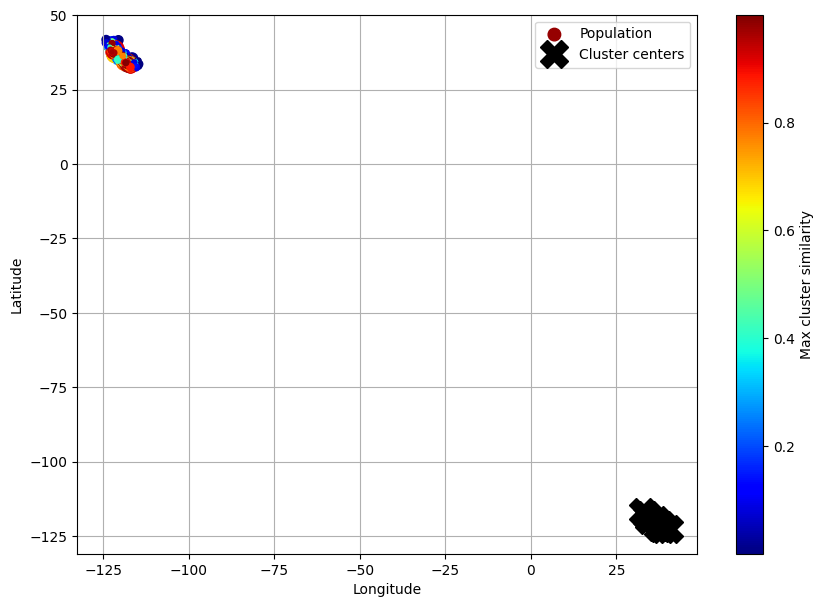

In [85]:
housing_renamed = df_housing_Features.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities_points.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_similarity.kmeans_.cluster_centers_[:, 1],
         cluster_similarity.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")


plt.show()

### **Transformation Pipelines**

In [87]:
from sklearn.pipeline import Pipeline

In [ ]:
numeric_pipeline = Pipeline([
    # "name" which must be unique and not contain double underscores
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

In [90]:
from sklearn import set_config
set_config(display="diagram")

numeric_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [91]:
from sklearn.pipeline import make_pipeline

In [92]:
numeric_pipeline1 = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

numeric_pipeline1

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [93]:
df_housing_Features_numerical_pipeline = numeric_pipeline1.fit_transform(df_housing_Features_numerical)

df_housing_Features_numerical_pipeline[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [95]:
df_housing_Features_numerical_pipeline_DataFrame = pd.DataFrame(df_housing_Features_numerical_pipeline, 
                                                                columns=numeric_pipeline1.get_feature_names_out(), 
                                                                index=df_housing_Features_numerical.index)

df_housing_Features_numerical_pipeline_DataFrame

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


**💡 Scikit-Learn Pipeline Behavior**

The "behavior" of the pipeline is determined entirely by its final component. Think of the pipeline as a single object that wraps all the individual steps into one clean interface:
- If the last step is a Transformer (like StandardScaler or PCA), the pipeline itself becomes a transformer. It gains the .transform() method.
- If the last step is a Predictor (like RandomForest or LinearRegression), the pipeline becomes a predictor. It gains the .predict() method.

**🔄 How the Data Flows**
> The pipeline handles the "hand-off" between steps automatically so you don't have to do it manually.

The Pipeline acts as a "wrapper" that inherits the methods of its **final estimator**.

| If the Last Step is a... | The Pipeline acts as a... | Main Method available |
| :--- | :--- | :--- |
| **Transformer** (e.g., `StandardScaler`) | **Transformer** | `.transform()` |
| **Predictor** (e.g., `RandomForest`) | **Predictor** | `.predict()` |

---

* **As a Transformer:** When you call `pipe.transform(X)`, the pipeline calls `.fit_transform()` on all intermediate steps and returns the final transformed data.
* **As a Predictor:** When you call `pipe.predict(X)`, the pipeline applies all transformations to the data first, then passes that result to the final model's `.predict()` method.

> **Key Benefit:** This ensures that your preprocessing and modeling are treated as a single unit, preventing **data leakage** and making your code much cleaner.

**Why this is useful**
- It prevents Data Leakage. Because the pipeline treats the transformations and the model as one single unit, you ensure that the exact same preprocessing logic used on your training data is applied to your test data or new "live" predictions.
- Instead of writing five lines of code to clean data before making a prediction, you just write one: pipeline.predict(X_new).

In [98]:
numeric_pipeline[1]

,copy,True
,with_mean,True
,with_std,True


In [99]:
numeric_pipeline["standardize"]

,copy,True
,with_mean,True
,with_std,True


In [100]:
from sklearn.compose import ColumnTransformer

In [104]:
numeric_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
category_attribs = ["ocean_proximity"]

category_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    # "name" which must be unique and not contain double underscores
    ("numeric", numeric_pipeline1, numeric_attribs),
    ("category", category_pipeline, category_attribs)
])

> hat is a crucial tip for keeping the ColumnTransformer clean and efficient. It allows us to precisely control which features enter in the model without manually slicing your DataFrame beforehand.

**🛠️ ColumnTransformer: Column Handling Options**

When defining transformations for specific columns, you can use these "short-hand" strings instead of an estimator:

| Special String | Action Taken |
| :--- | :--- |
| **"drop"** | The specified columns are removed entirely from the output. |
| **"passthrough"** | The columns are kept as-is (no scaling/encoding) and concatenated to the output. |

---

**📡 The `remainder` Hyperparameter**
> By default, any columns **not** explicitly listed in your `ColumnTransformer` are **dropped**. You can change this behavior globally:

* **`remainder="drop"`** (Default): Discards all unlisted columns.
* **`remainder="passthrough"`**: Keeps all unlisted columns and appends them to the transformed data.
* **`remainder=Estimator()`**: Applies a specific transformer (like `StandardScaler()`) to all remaining columns.

> **Note:** Using `passthrough` is very common when you have pre-processed features that don't need further scaling but still need to be part of the final feature matrix.

**🛠️ Advanced ColumnTransformer Configuration**

In `ColumnTransformer`, you don't always need a formal transformer object. You can use strings to simplify your preprocessing logic.

| Setting | Action | Result |
| :--- | :--- | :--- |
| **`"drop"`** | Discard columns | Removes the columns from the output entirely. |
| **`"passthrough"`** | Leave untouched | Keeps the columns exactly as they are in the output. |
| **`remainder`** | Global behavior | Handles any columns **not** explicitly mentioned in the transformer list. |

---

**💻 Code Implementation Example**

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the transformer
ct = ColumnTransformer([
        ("scale", StandardScaler(), ["age", "income"]),        # Scale these
        ("encode", OneHotEncoder(), ["city"]),                 # Encode these
        ("remove_id", "drop", ["user_id"]),                    # Explicitly drop
        ("keep_raw", "passthrough", ["zip_code"])              # Keep as-is
    ], 
    remainder="passthrough" # Keep all other unmentioned columns
)

In [101]:
from sklearn.compose import make_column_selector, make_column_transformer

In [113]:
preprocessing = make_column_transformer(
    (numeric_pipeline1, make_column_selector(dtype_include=np.number)),
    (category_pipeline, make_column_selector(dtype_include=object))
)

In [115]:
df_housing_prepared = preprocessing.fit_transform(df_housing_Features)

df_housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]], shape=(16512, 13))

In [116]:
df_housing_prepared_DataFrame = pd.DataFrame(df_housing_prepared, columns=preprocessing.get_feature_names_out(), index=df_housing_Features.index)

df_housing_prepared_DataFrame.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


**How Scikit-Learn handles memory efficiency behind the scenes** 
> When you combine high-cardinality categorical data (which creates many zeros) with numerical data, the ColumnTransformer has to decide whether to store the result as a Sparse Matrix (efficient for zeros) or a Dense Matrix (a standard NumPy array).

**🧠 ColumnTransformer: Sparse vs. Dense Outputs**

> When combining different types of data (e.g., One-Hot Encoded categories and Scaled numbers), the `ColumnTransformer` automatically decides the output format based on **Density**.

| Matrix Type | Property | Best For... |
| :--- | :--- | :--- |
| **Sparse** | Only stores non-zero values. | Categorical data with many unique values. |
| **Dense** | Stores every single cell (standard array). | Numerical data or small datasets. |

---

**📏 The `sparse_threshold` Logic**

The transformer calculates the **Density Ratio** ($\frac{\text{Non-zero cells}}{\text{Total cells}}$):

* **If Density < 0.3 (30%)**: Returns a **Sparse Matrix**.
* **If Density > 0.3 (30%)**: Returns a **Dense Matrix** (NumPy array).



> **Note:** You can manually override this by setting `sparse_threshold=0` (always dense) or `sparse_threshold=1` (always sparse) inside the `ColumnTransformer` or `make_column_transformer` constructor.